In [0]:
#unzip data diles

!unzip -q -o test.zip
!unzip -q -o train.zip

In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
from matplotlib.image import imread

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
SEED = 257

TRAIN_DIR = 'train/'
TEST_DIR = 'test/'

In [0]:
categories = ['hot dog', 'not hot dog']

In [0]:
X, y = [], []

for category in categories:
    category_dir = os.path.join(TRAIN_DIR, category)
    for image_path in os.listdir(category_dir):
        X.append((os.path.join(category_dir, image_path)))
        y.append(category)

df = pd.DataFrame({
    'filename': X,
    'category': y
})

In [8]:
len(X), len(y)

(10049, 10049)

In [9]:
#training dataframe

df

,filename,category
0,train/hot dog/91ef557ad4f8256e204407335ed75dbe...,hot dog
1,train/hot dog/db41cac241a5072ec56cb97a667dc6d4...,hot dog
2,train/hot dog/180ceb4eb696a2eeb0231624a6090ab7...,hot dog
3,train/hot dog/55eb24fa27e1ce30ec49319a107e1bd1...,hot dog
4,train/hot dog/c8260a0fec516e840982baf00639b1a7...,hot dog
...,...,...
10044,train/not hot dog/96a0a13465f56f7416cde57451c3...,not hot dog
10045,train/not hot dog/fbc6dc5b551eba0d6801a440c30c...,not hot dog
10046,train/not hot dog/d1d4fb4a55ed122dd1f0c71df472...,not hot dog
10047,train/not hot dog/b938f4061decdd5f9ac47b2564f3...,not hot dog


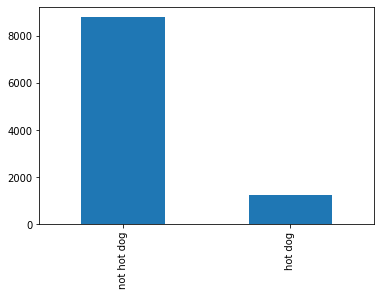

In [10]:
#we actually have class imbalance

df['category'].value_counts().plot.bar()

In [11]:
#I will use VGG16 application as a pre-trained model

from tensorflow.keras.applications import VGG16
#Load the VGG model
image_size = 100
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [12]:
# Freeze the layers except the last 4 layers
for layers in (vgg_conv.layers)[:-4]:
    print(layers)
    layers.trainable = False

In [13]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
# Create the model
model = models.Sequential()

# Add the vgg convolutional base model

model.add(vgg_conv)
# Add new layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))


# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

In [0]:
#compile model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
#reduce learning rate when a metric has stopped improving

from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [learning_rate_reduction]

In [0]:
#create training and testing dataset

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

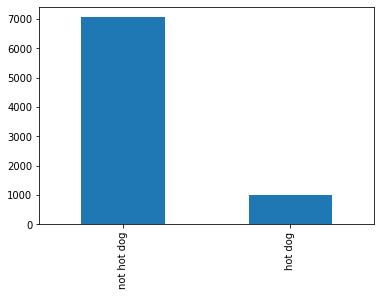

In [17]:
train_df['category'].value_counts().plot.bar()

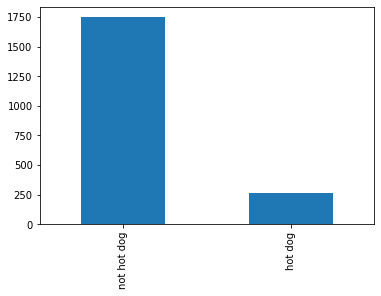

In [18]:
validate_df['category'].value_counts().plot.bar()

In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15
total_validate

2010

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filename',
    y_col='category',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=15
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    x_col='filename',
    y_col='category',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=batch_size
)

Found 8039 validated image filenames belonging to 2 classes.
Found 2010 validated image filenames belonging to 2 classes.


In [21]:
epochs=3 if False else 30
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
535/535 [==============================] - 45s 85ms/step - loss: 0.3407 - accuracy: 0.8837 - val_loss: 0.2910 - val_accuracy: 0.9149 - lr: 0.0010
Epoch 2/30
535/535 [==============================] - 45s 84ms/step - loss: 0.2320 - accuracy: 0.9159 - val_loss: 0.1955 - val_accuracy: 0.9249 - lr: 0.0010
Epoch 3/30
535/535 [==============================] - 45s 84ms/step - loss: 0.1856 - accuracy: 0.9367 - val_loss: 0.1735 - val_accuracy: 0.9368 - lr: 0.0010
Epoch 4/30
535/535 [==============================] - 45s 84ms/step - loss: 0.2097 - accuracy: 0.9255 - val_loss: 0.1942 - val_accuracy: 0.9269 - lr: 0.0010
Epoch 5/30
535/535 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9443
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
535/535 [==============================] - 45s 84ms/step - loss: 0.1690 - accuracy: 0.9443 - val_loss: 0.2267 - val_accu

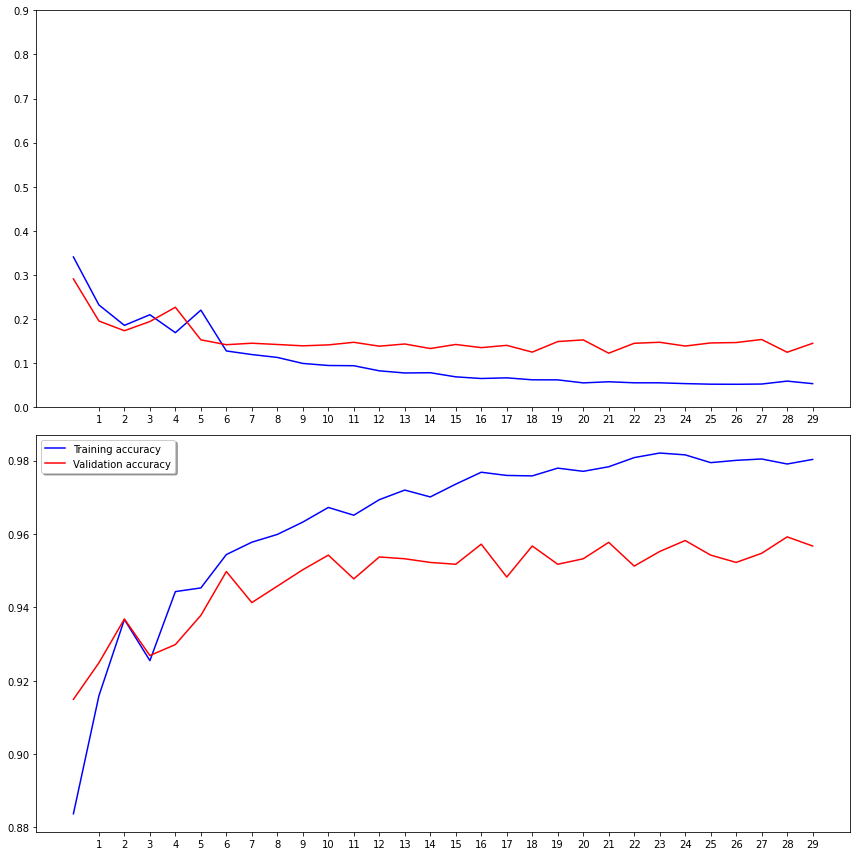

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


ERROR! Session/line number was not unique in database. History logging moved to new session 59


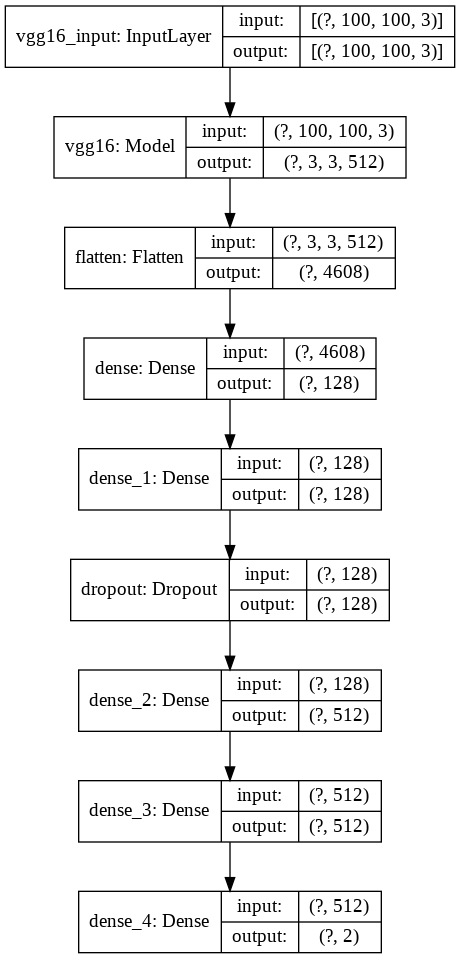

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [27]:
#predict validation data

predict_for_validation = model.predict(validation_generator,steps=np.ceil(total_validate/batch_size))
predict_for_validation

array([[3.5209989e-04, 9.9964786e-01],
       [8.0811059e-01, 1.9188938e-01],
       [0.0000000e+00, 1.0000000e+00],
       ...,
       [9.5803432e-35, 1.0000000e+00],
       [4.8291385e-02, 9.5170861e-01],
       [2.5809489e-02, 9.7419047e-01]], dtype=float32)

In [28]:
#create copy of validate_df

validate_df2 = pd.DataFrame({
    'filename': validate_df['filename'],
    'category': validate_df['category']
})
validate_df2[:5]

,filename,category
0,train/hot dog/f47615a37e855ca88f549a358b301ef8...,hot dog
1,train/not hot dog/63c605f2598c5c1a3dbf46dc4636...,not hot dog
2,train/not hot dog/372b37e78fe8e449fdab83f67eb7...,not hot dog
3,train/not hot dog/c99426115e5f512d8719ec71ad0b...,not hot dog
4,train/not hot dog/609a729e83a570b3c6833de2338c...,not hot dog


In [29]:
#create array of validation images

leaderboard_X2 = []
validate_df22 = np.asarray(validate_df2['filename'])
for x in range(0,len(validate_df22)):
  i = imread(validate_df22[x])
  leaderboard_X2.append(i)
len(leaderboard_X2)

2010

In [30]:
# predict validation probabilities

leaderboard_X2 = np.asarray(leaderboard_X2)

validation_probabilities = model.predict_proba(leaderboard_X2)
validation_probabilities[:10]

Instructions for updating:
Please use `model.predict()` instead.


array([[7.8678620e-01, 2.1321382e-01],
       [1.5987300e-19, 1.0000000e+00],
       [7.8126296e-02, 9.2187369e-01],
       [4.5795598e-05, 9.9995422e-01],
       [2.4346678e-08, 1.0000000e+00],
       [1.6669278e-08, 1.0000000e+00],
       [2.0779307e-08, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.4016114e-04, 9.9985981e-01],
       [6.9517996e-06, 9.9999309e-01]], dtype=float32)

In [0]:
# choose probabilities of class 1

not_hot_dog_validation_probabilities = []
for i in validation_probabilities:
  class1 = i[1]
  not_hot_dog_validation_probabilities.append(class1)

In [37]:
not_hot_dog_validation_probabilities[:10]

[0.21321382,
 1.0,
 0.9218737,
 0.9999542,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9998598,
 0.9999931]

In [0]:
validate_df2['category'] = validate_df2['category'].replace({ 'hot dog': 0, 'not hot dog': 1 })
np_validate_df2 = validate_df2['category'].to_numpy() #create array of classes of the validation set

In [34]:
len(np_validate_df2)

2010

In [38]:
# ROC-AUC score

score = roc_auc_score(np_validate_df2,not_hot_dog_validation_probabilities)
score

0.9724679895889741

In [0]:
from sklearn.metrics import roc_curve, accuracy_score
fpr , tpr , thresholds = roc_curve(np_validate_df2,not_hot_dog_validation_probabilities)

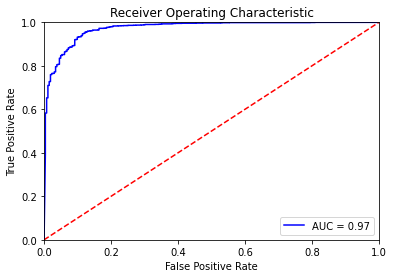

In [40]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % score)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
#create test data

test_filenames = os.listdir('test/test/')
test_filenames = [f for f in test_filenames if str(f).strip().endswith('.png')]
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [42]:
test_df['filename']

0       4f2c5e64d0ed1eed5f4fedf5425b075ee4cbed46df7081...
1       3dda0349f95b58e95a2e8e2d0cdebce331d3bf1a452198...
2       6aeb1880181db9350f8068b79fb4280a9dcece75a2cce6...
3       4ef1366a8ad3974bb8657516219f27bce63de06b85825b...
4       2e5d6bf18243ce4b77647d87b2cd46e0b35786741c4405...
                              ...                        
1998    6b1b9b9d696eb4a7f5bb8a6c98fbc04dfee6e16f15d7c1...
1999    0bc70dd08666302add0219d0dae7a4187bc77cbbf64b9a...
2000    6dd4d88f59dc208c7ade9e264bfaf0ffea0e65303e0768...
2001    1fee52525bb0b03fc1c23ca7e68c5d7523cf1cc5f790fd...
2002    4f873060655878f94bf8582e1db597a19e306a0da476d5...
Name: filename, Length: 2003, dtype: object

In [43]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    'test/test/',
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(100,100),
    batch_size=batch_size,
    shuffle=False
)

Found 2003 validated image filenames.


In [44]:
# predict test data
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))
predict

array([[7.7148800e-04, 9.9922848e-01],
       [6.2841253e-04, 9.9937159e-01],
       [1.2052984e-02, 9.8794705e-01],
       ...,
       [1.7439622e-02, 9.8256034e-01],
       [4.0701684e-03, 9.9592978e-01],
       [7.5762767e-01, 2.4237232e-01]], dtype=float32)

In [0]:
test_df['category'] = ""

In [46]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df

,filename,category
0,4f2c5e64d0ed1eed5f4fedf5425b075ee4cbed46df7081...,1
1,3dda0349f95b58e95a2e8e2d0cdebce331d3bf1a452198...,1
2,6aeb1880181db9350f8068b79fb4280a9dcece75a2cce6...,1
3,4ef1366a8ad3974bb8657516219f27bce63de06b85825b...,1
4,2e5d6bf18243ce4b77647d87b2cd46e0b35786741c4405...,1
...,...,...
1998,6b1b9b9d696eb4a7f5bb8a6c98fbc04dfee6e16f15d7c1...,0
1999,0bc70dd08666302add0219d0dae7a4187bc77cbbf64b9a...,1
2000,6dd4d88f59dc208c7ade9e264bfaf0ffea0e65303e0768...,1
2001,1fee52525bb0b03fc1c23ca7e68c5d7523cf1cc5f790fd...,1


In [47]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

label_map

{0: 'hot dog', 1: 'not hot dog'}

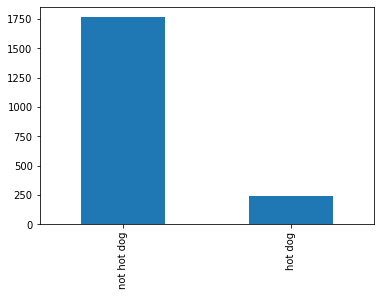

In [48]:
test_df['category'].value_counts().plot.bar()

In [49]:
test_df['category'][:15]

0     not hot dog
1     not hot dog
2     not hot dog
3     not hot dog
4     not hot dog
5     not hot dog
6         hot dog
7     not hot dog
8     not hot dog
9         hot dog
10    not hot dog
11    not hot dog
12    not hot dog
13    not hot dog
14    not hot dog
Name: category, dtype: object

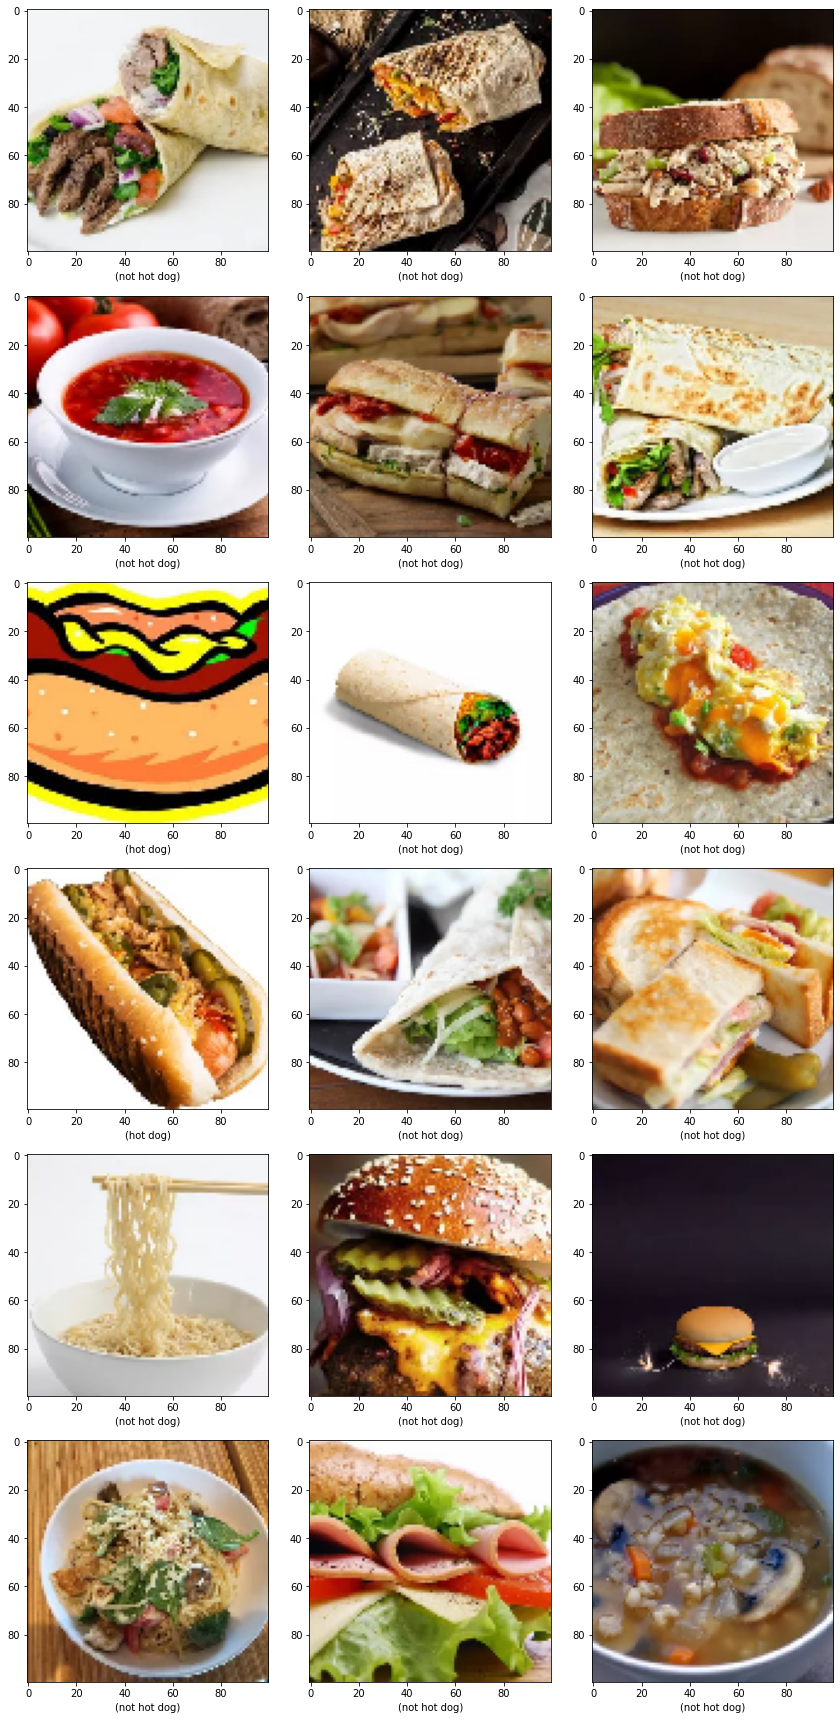

In [50]:
from keras.preprocessing.image import load_img
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test/test/"+filename, target_size=(100,100))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel('(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [0]:
model.save_weights("modelvgg.h5")

In [0]:
#create test data filenames and probabilities dataframe

leaderboard_X = []
leaderboard_filenames = []

In [0]:
#create first column of filenames

for image_path in os.listdir('test/test/'):
  if image_path=='.DS_Store':
    continue
  else:
    x = imread(os.path.join('test/test/', image_path))
    leaderboard_X.append(x)
leaderboard_filenames = test_df['filename'].tolist()

In [56]:
# read images and predict probabilities

leaderboard_X = np.asarray(leaderboard_X)

probabilities = model.predict_proba(leaderboard_X)
probabilities[20],leaderboard_filenames[24]

(array([0., 1.], dtype=float32),
 '02e5b22b8667fe8dd1cece6083f255de0a2d9fcb7206392a758c06978cef4b1d.png')

In [57]:
# create array of probabilities for class 0

hot_dog_probability = []
for i in probabilities:
  class0 = i[0]
  hot_dog_probability.append(class0)
hot_dog_probability[:10]

[0.00077150087,
 0.00062841555,
 0.012052927,
 0.0,
 0.12450599,
 0.00010352633,
 0.9884321,
 0.004665851,
 0.030673197,
 0.99999976]

In [0]:
submission = pd.DataFrame(
    {
        'image_id': leaderboard_filenames, 
        'image_hot_dog_probability': hot_dog_probability
    }
)

In [0]:
submission.to_csv('submitfinal.csv', index=False)

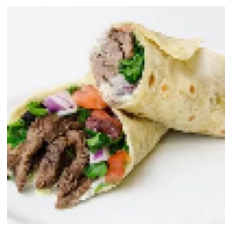

In [60]:
plt.axis("off");
plt.imshow(leaderboard_X[0]);